In [1]:
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

%matplotlib inline

In [2]:
resize = 128
crop_size = 112
batch_size = 32
file_name = "mobilenet_v2_112"
os.makedirs("weight", exist_ok=True)

In [3]:
transform_dict = {
    "train": transforms.Compose(
        [
            transforms.Resize((resize, resize)),
            transforms.RandomRotation(180),
            transforms.RandomResizedCrop(crop_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize((resize, resize)),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

In [4]:
data_train = torchvision.datasets.ImageFolder(
    root="./data", transform=transform_dict["train"]
)
data_test = torchvision.datasets.ImageFolder(
    root="./data", transform=transform_dict["test"]
)

train_loader = torch.utils.data.DataLoader(
    data_train, batch_size=32, shuffle=True, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    data_test, batch_size=32, shuffle=False, num_workers=4
)

In [5]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


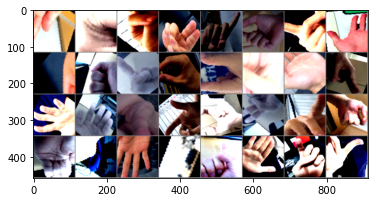

tensor(0) tensor(2) tensor(1) tensor(4) tensor(3) tensor(2) tensor(3) tensor(0)


In [6]:
# 訓練データをランダムに取得
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % labels[labels[j]] for j in range(8)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


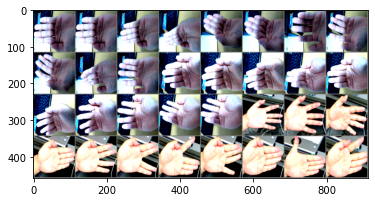

tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0)


In [7]:
# テストデータを取得
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % labels[labels[j]] for j in range(8)))

In [8]:
model = models.mobilenet_v2(pretrained=True)
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2, inplace=False), nn.Linear(in_features, 5)
)

In [9]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Using cuda device


In [10]:
def train(dataloader, model, loss_fn, optimizer):
    for (X, y) in tqdm(dataloader, total=len(dataloader)):
        X, y = X.to(device), y.to(device)

        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)

        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [11]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [12]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model)
print("Done!")

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1
-------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 52.0%, Avg loss: 0.041174 

Epoch 2
-------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 62.8%, Avg loss: 0.031299 

Epoch 3
-------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 64.8%, Avg loss: 0.027653 

Epoch 4
-------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 76.7%, Avg loss: 0.022734 

Epoch 5
-------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 74.9%, Avg loss: 0.021455 

Epoch 6
-------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 82.3%, Avg loss: 0.015923 

Epoch 7
-------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 80.1%, Avg loss: 0.019534 

Epoch 8
-------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 84.4%, Avg loss: 0.014603 

Epoch 9
-------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 82.9%, Avg loss: 0.014379 

Epoch 10
-------------------------------


100%|██████████| 17/17 [00:12<00:00,  1.37it/s]


Test Error: 
 Accuracy: 79.9%, Avg loss: 0.017116 

Done!


In [13]:
model.eval()
torch.save(model.to("cpu").state_dict(), "weight/" + file_name + ".pth")

In [14]:
# Input to the model
x = torch.randn(batch_size, 3, crop_size, crop_size, requires_grad=True)

# Export the model
torch.onnx.export(model,               # 対象モデル
                  x,                         # 入力サンプル
                  "weight/" + file_name + ".onnx",   # 保存先
                  export_params=True,        # モデルファイルに訓練した重みを保存するかどうか
                  opset_version=10,          # ONNXのバージョン
                  do_constant_folding=True,  # constant folding for optimizationを実施するかどうか
                  input_names = ['input'],   # モデルへの入力変数名
                  output_names = ['output'], # モデルの出力変数名
                  dynamic_axes={'input' : {0 : 'batch_size'},    # 動的軸（dynamic axes）の指定
                                'output' : {0 : 'batch_size'}})